<a href="https://www.kaggle.com/code/nirmit27/transaction-fraud-predictor?scriptVersionId=205998527" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Transaction Fraud Prediction**

## Importing the necessary libraries

In [69]:
import os
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# 

#### Settings for the graphs

In [44]:
plt.style.use("seaborn-v0_8")
init_notebook_mode(connected=True)

#### Suppressing warnings

In [19]:
import warnings
warnings.filterwarnings("ignore")

## Importing the dataset

In [20]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/onlinefraud.csv


In [21]:
df = pd.read_csv(r'/kaggle/input/onlinefraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Data Cleaning

### Missing Value Imputation
Checking the dataset for any missing values

In [23]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### Observation
This dataset's features do **not** have any missing values that need imputation.

### Treating Outliers
Removing **outliers** from the numerical features

In [24]:
num_cols = [col for col in df.columns if df[col].dtype != 'object']
num_cols[:]

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [25]:
df[num_cols[1:-2]].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


#### BOXPLOTS

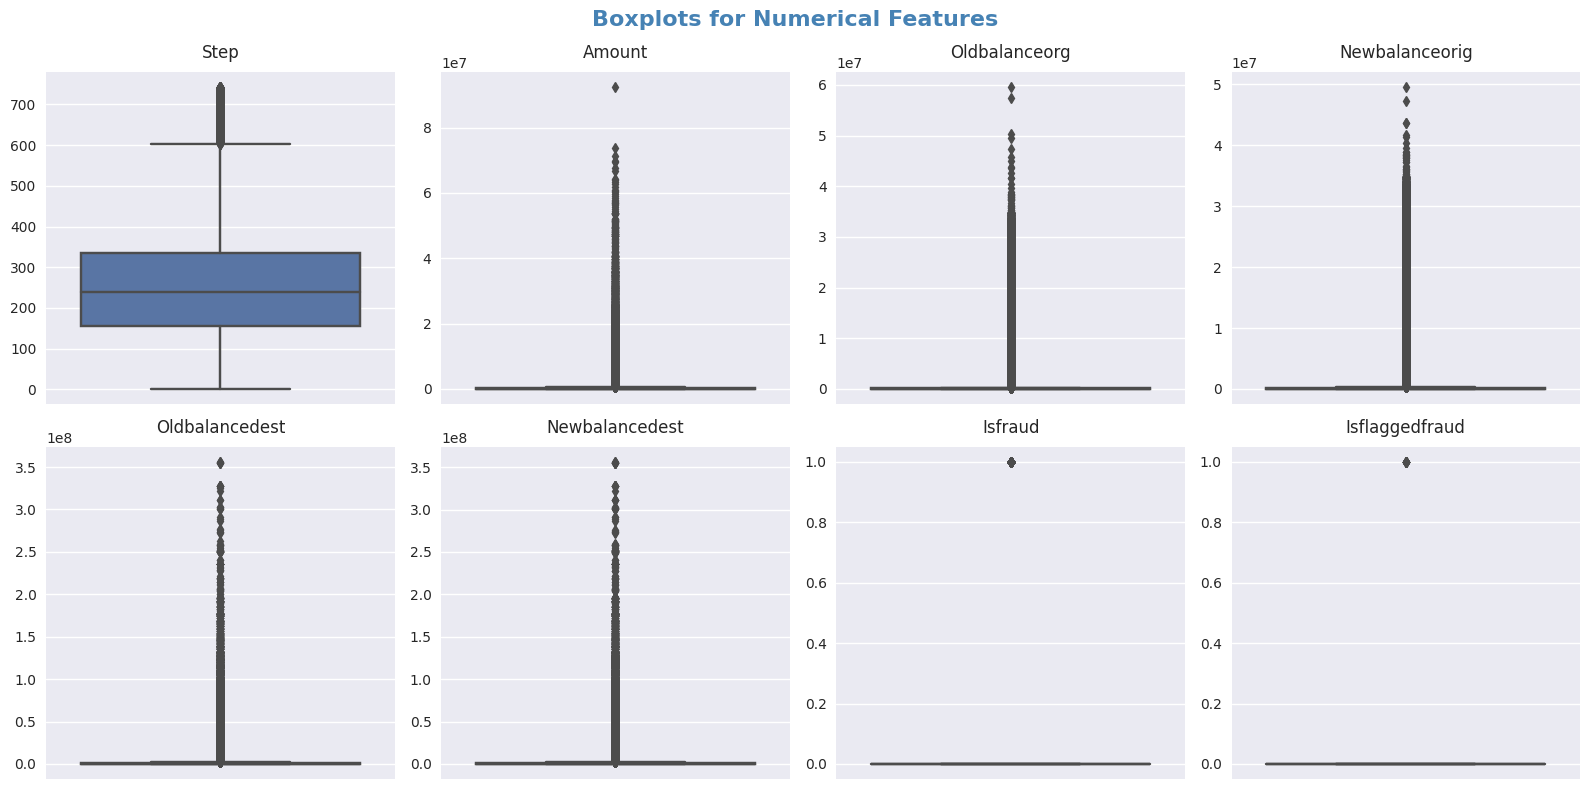

In [26]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
fig.suptitle("Boxplots for Numerical Features", fontsize=16, fontweight='bold', color='steelblue')

for i in range(len(num_cols)):
    sns.boxplot(df[num_cols[i]], ax=axs.flatten()[i])
    axs.flatten()[i].set_title(num_cols[i].title(), pad=10)
    axs.flatten()[i].set_xticks([])

plt.tight_layout()
plt.show()

#### Observation
There are lots of outliers in the numerical features, **but we cannot ignore them** since our problem statement is to distinguish the ***fraudulent*** transactions from the ***non-fraudulent*** transactions, which requires the special consideration of transactions that deal with **extremely high amounts of money** (for instance, above `200,000.00`) in comparison to the amount of money within the 50th or 75th percentile.

##### Consider the output of the code cell below :

In [27]:
mask = (df['isFlaggedFraud'] == 1) & (df.amount > 200000.00) & (df.isFraud == 1)
df[mask][num_cols[1:-2]]

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2736446,4953893.08,4953893.08,4953893.08,0.0,0.0
3247297,1343002.08,1343002.08,1343002.08,0.0,0.0
3760288,536624.41,536624.41,536624.41,0.0,0.0
5563713,4892193.09,4892193.09,4892193.09,0.0,0.0
5996407,10000000.00,19585040.37,19585040.37,0.0,0.0
5996409,9585040.37,19585040.37,19585040.37,0.0,0.0
6168499,3576297.10,3576297.10,3576297.10,0.0,0.0
6205439,353874.22,353874.22,353874.22,0.0,0.0
6266413,2542664.27,2542664.27,2542664.27,0.0,0.0
6281482,10000000.00,10399045.08,10399045.08,0.0,0.0


As we can see, the **fraudulent** transactions involving an `amount` value **greater than 200000.00** have been successfully marked as `1` and hence, these values **should not** be capped by winsorization or any other outlier treatment techniques.

### Multicollinearity
Checking the features for eliminating **multicollinearity** using **Variance Inflation Factor**

#### HEATMAP

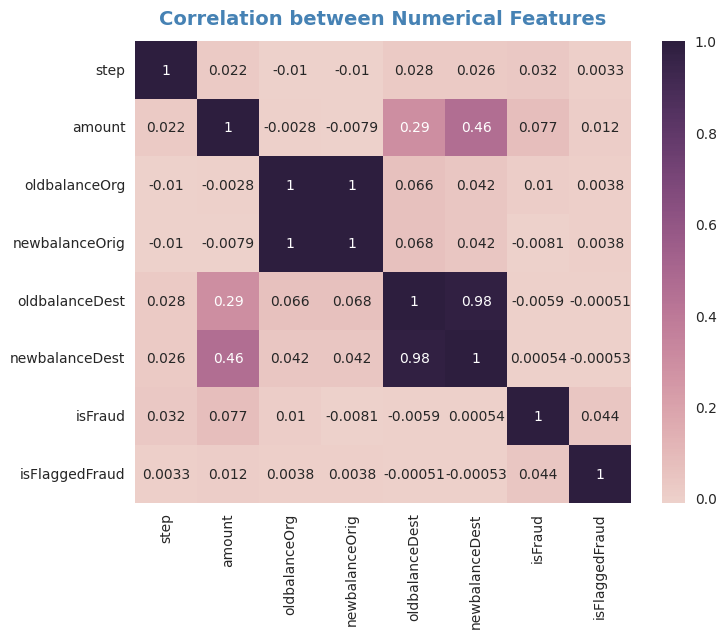

In [28]:
plt.figure(figsize=(8, 6))
plt.title("Correlation between Numerical Features", fontsize=14, fontweight='bold', color='steelblue', pad=12)

sns.heatmap(df[num_cols].corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

#### Observations
1. There is a **strong positive** correlation between `newbalanceDest` and `oldbalanceDest`.
2. There is a **strong positive** correlation between `newbalanceOrig` and `oldbalanceOrg`.
3. There is some **positive** correlation between `amount` and `newbalanceDest`.

#### FUNCTION for computing VIF values

In [29]:
def find_vif(cols):
    print("Variance Inflation Factors of Numerical Columns -\n")
    for i in range(df[cols].shape[1]):
        vif_value = vif(df[cols], i)
        print(f"{cols[i].title()} : {vif_value}")

In [30]:
find_vif(num_cols)

Variance Inflation Factors of Numerical Columns -

Step : 1.1910935708661254
Amount : 4.078951905253257
Oldbalanceorg : 544.0531028288392
Newbalanceorig : 546.3460079624596
Oldbalancedest : 72.89552215169822
Newbalancedest : 84.58461924348019
Isfraud : 1.1883855017662892
Isflaggedfraud : 1.002546154407714


We can remove the columns that have a **strong positive correlation** with the columns that have **VIF value > 5** to eliminate multicollinearity.

In [31]:
test = [col for col in num_cols if col not in ['newbalanceOrig', 'newbalanceDest']]
find_vif(test)

Variance Inflation Factors of Numerical Columns -

Step : 1.1680936804978963
Amount : 1.1897471520554581
Oldbalanceorg : 1.0663849079426269
Oldbalancedest : 1.2069708150342995
Isfraud : 1.0108032621399474
Isflaggedfraud : 1.0020492740989582


## EDA

### Types of Transactions
Visually depicting the types of transactions in the dataset

In [57]:
t_types = df['type'].value_counts().reset_index()
t_types

,type,count
0,CASH_OUT,2237500
1,PAYMENT,2151495
2,CASH_IN,1399284
3,TRANSFER,532909
4,DEBIT,41432


In [82]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"}, {"type": "pie"}]])

colors = ['steelblue', 'mediumseagreen', 'tomato', 'goldenrod', 'mediumpurple']

fig.add_trace(
    go.Bar(x=t_types['type'], y=t_types['count'], marker_color=colors, showlegend=False),
    row=1, col=1
)
fig.update_xaxes(title_text="Type of transaction", row=1, col=1)
fig.update_yaxes(title_text="Number of Transactions", row=1, col=1)

fig.add_trace(
    go.Pie(values=df['type'].value_counts().values, 
           labels=df['type'].value_counts().index, 
           hole=0.4),
    row=1, col=2
)

fig.update_layout(
    title_text="Types of Transactions",
    title_font_size=20,
    title_font_color='steelblue',
    title_font_weight='bold',
    showlegend=True,
    legend_title_text="Type of Transaction" 
)
fig.show(renderer='iframe')

#### Observation
Most of the transactions are **cash withdrawals** or **transfers** in nature.

In [ ]:
# ... 